In [1]:
import geopandas as gpd
import libpysal as lps
import seaborn as sns
import numpy as np
import tobler as tob
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

In [2]:
schools = gpd.read_file('schools.shp')

<AxesSubplot:>

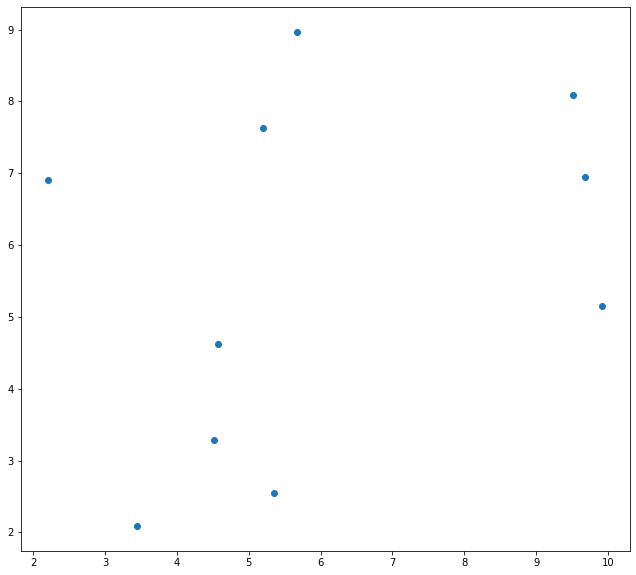

In [3]:
schools.plot()

In [5]:
schools.head()

,test_score,geometry
0,84.621952,POINT (9.51702 8.08617)
1,62.359065,POINT (5.19649 7.63378)
2,38.022265,POINT (2.20963 6.90364)
3,15.609321,POINT (4.51316 3.28197)
4,78.779343,POINT (5.67809 8.96656)


<AxesSubplot:>

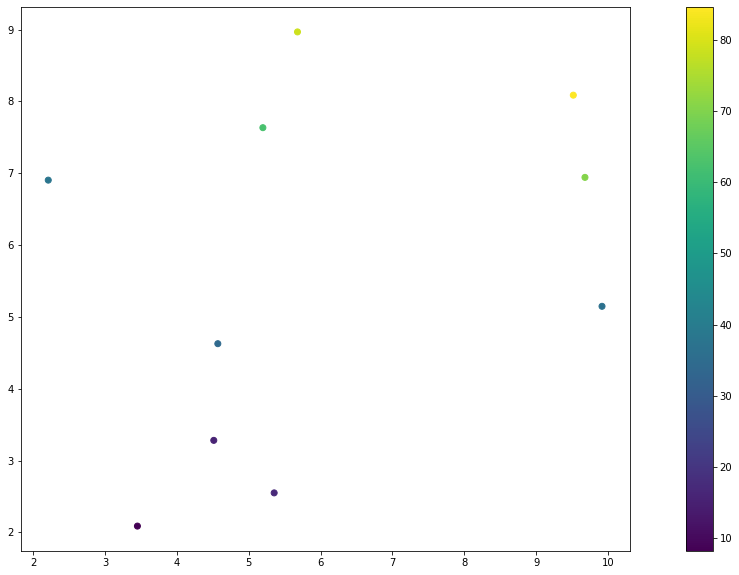

In [7]:
schools.plot(column='test_score', legend=True)

In [8]:
env = gpd.read_file('env.shp')

<AxesSubplot:>

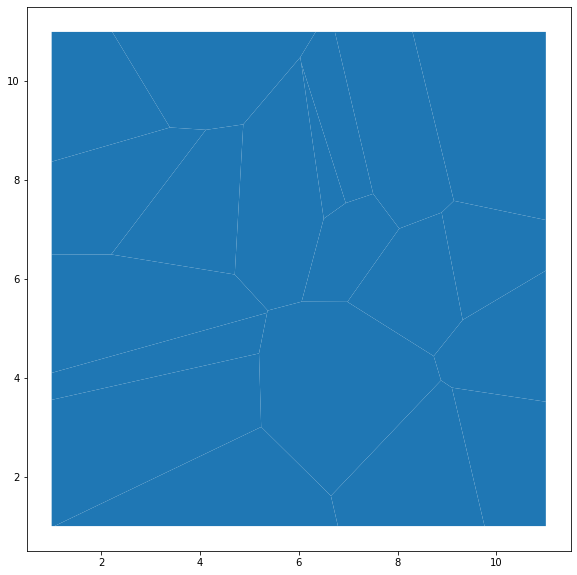

In [9]:
env.plot()

<AxesSubplot:>

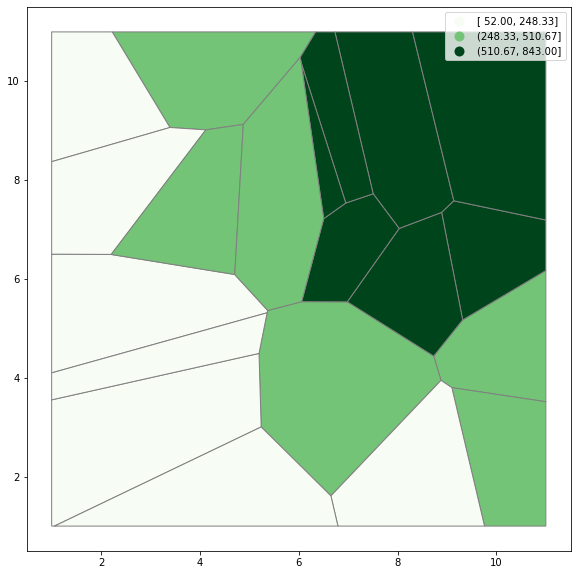

In [10]:
env.plot(column='escore', cmap='Greens', scheme='Quantiles', k=3,edgecolor='grey',
        legend=True)

In [11]:
dem = gpd.read_file('demo.shp')

In [12]:
dem.head()

,black,white,total,pctw,pctb,geometry
0,64,336,400,0.8400,0.1600,"POLYGON ((3.60031 8.34527, 4.31160 7.14336, 3...."
1,114,286,400,0.7150,0.2850,"POLYGON ((3.36733 4.62828, 3.41913 5.02266, 3...."
2,147,253,400,0.6325,0.3675,"POLYGON ((2.27505 3.93207, 2.73347 3.66886, 2...."
3,44,356,400,0.8900,0.1100,"POLYGON ((4.95479 8.51631, 5.64418 6.97012, 5...."
4,25,375,400,0.9375,0.0625,"POLYGON ((8.89679 8.93948, 9.46456 11.00000, 1..."


<AxesSubplot:>

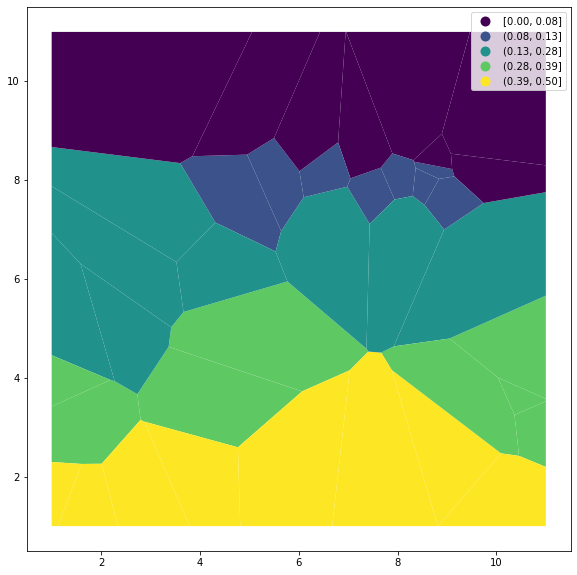

In [13]:
dem.plot(column='pctb', scheme='Quantiles', k=5, legend=True)

# Overlays

<AxesSubplot:>

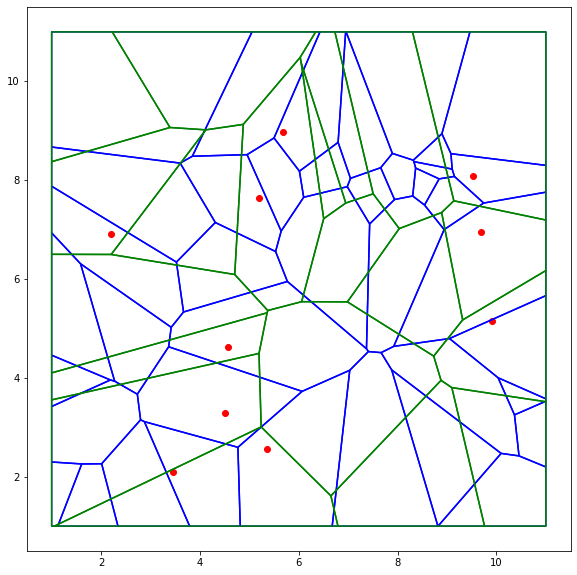

In [14]:
base = dem.geometry.boundary.plot(edgecolor='blue')
env.geometry.boundary.plot(ax=base, edgecolor='green')
schools.plot(color='red', ax=base)

## Issues: Data Integration and Change of Support

We have three sources of data

- 40 census block groups with white/black population counts (blue polygons)
- 20 environmental monitoring zones with measurements of envl quality (green polygons)
- 10  schools with x,y addresses and test scores (red points)

## Objective

Explore relationship between school test score and environmental quality and racial composition of neighborhoods

## Tasks
1. Construct values of environmental quality for each school
2. Construct racial composition measure for each school
3. Explore associations of interest

### Environmental Quality for the Schools

Two approaches:
    
 1. Take the value for the environmental zone that contains the school (1-1)
 2. Consruct a value that represents the environmental quality in the neighborhoods closes to the school (1-many)

#### Approach 1 Spatial Join

<AxesSubplot:>

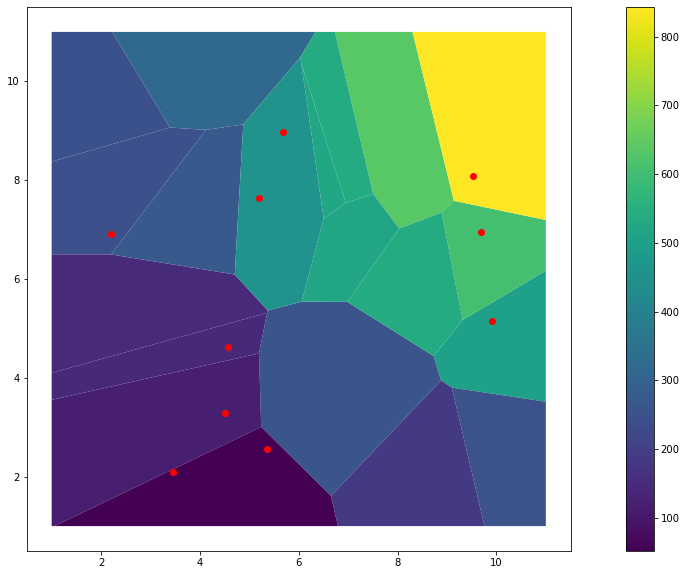

In [25]:
base  = env.plot(column='escore', legend=True)
schools.plot(color='red', ax=base)

In [20]:
schools_escore1 = gpd.sjoin(schools, env, how='left', op='within')

In [21]:
schools_escore1

,test_score,geometry,index_right,escore
0,84.621952,POINT (9.51702 8.08617),17,843
1,62.359065,POINT (5.19649 7.63378),19,457
2,38.022265,POINT (2.20963 6.90364),3,244
3,15.609321,POINT (4.51316 3.28197),6,119
4,78.779343,POINT (5.67809 8.96656),19,457
5,8.197455,POINT (3.45039 2.08885),16,52
6,36.774020,POINT (9.91645 5.14755),0,498
7,34.190434,POINT (4.56939 4.62751),8,140
8,17.116259,POINT (5.35361 2.55102),16,52
9,70.448306,POINT (9.67917 6.94204),9,608


In [23]:
schools['escore1'] = schools_escore1.escore

In [24]:
schools.head()

,test_score,geometry,escore1
0,84.621952,POINT (9.51702 8.08617),843
1,62.359065,POINT (5.19649 7.63378),457
2,38.022265,POINT (2.20963 6.90364),244
3,15.609321,POINT (4.51316 3.28197),119
4,78.779343,POINT (5.67809 8.96656),457


#### Approach 2 Areal Interpolation

In [26]:
x = schools.geometry.x
y = schools.geometry.y
cents = np.array([x,y]).T
cents

array([[9.51701587, 8.08616908],
       [5.19648984, 7.63377611],
       [2.2096302 , 6.90364234],
       [4.51315767, 3.28196787],
       [5.67809252, 8.96655834],
       [3.45038947, 2.08884618],
       [9.91645282, 5.14755442],
       [4.56939098, 4.62751352],
       [5.35361221, 2.55102112],
       [9.67917039, 6.94203637]])

In [27]:
schools_vd, school_cents = lps.cg.voronoi_frames(cents)

<AxesSubplot:>

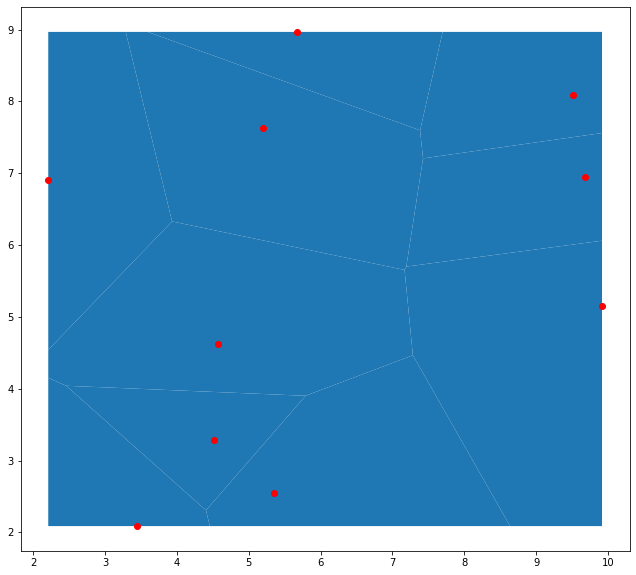

In [28]:
base = schools_vd.plot()
schools.plot(ax=base, color='red')

<AxesSubplot:>

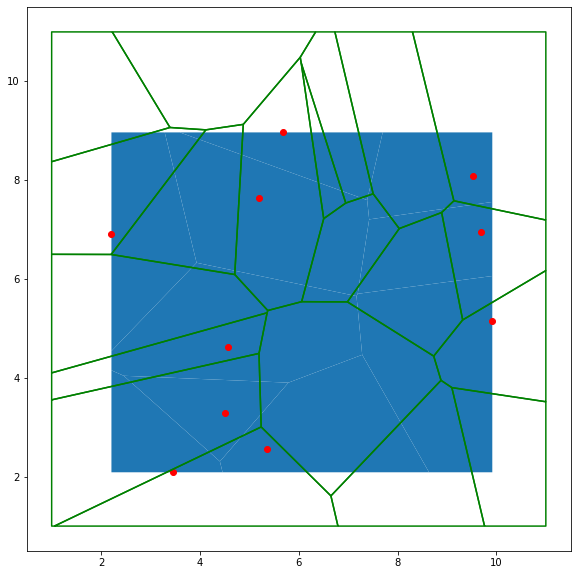

In [29]:
base = env.geometry.boundary.plot(edgecolor='green')
schools_vd.plot(ax=base)
schools.plot(ax=base, color='red')

In [30]:
schools_vd, school_cents = lps.cg.voronoi_frames(cents, clip = env.unary_union)

<AxesSubplot:>

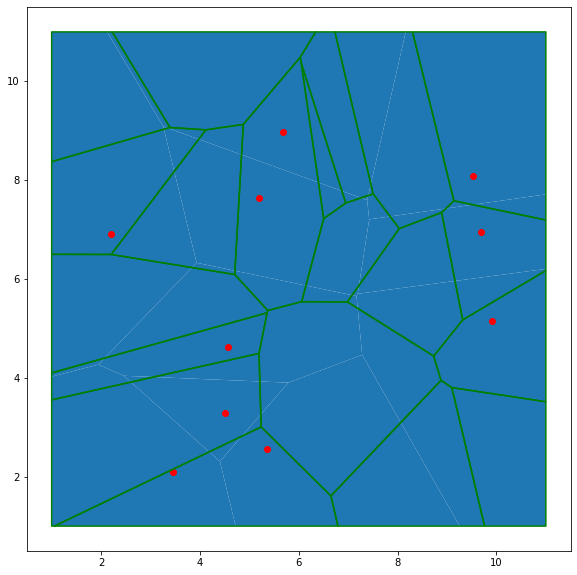

In [31]:
base = env.geometry.boundary.plot(edgecolor='green')
schools_vd.plot(ax=base)
schools.plot(ax=base, color='red')

<AxesSubplot:>

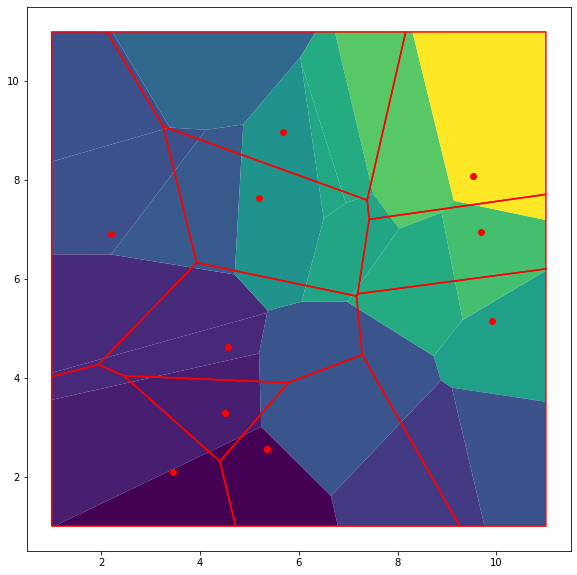

In [32]:
base = env.plot(column='escore')
schools_vd.geometry.boundary.plot(ax=base, edgecolor='red')
schools.plot(ax=base, color='red')

Estimate the escore for a school using areal interpolation

In [33]:
escore = tob.area_weighted.area_interpolate(source_df=env,
                                           target_df=schools_vd,
                                           intensive_variables=['escore'])

In [34]:
escore

,escore,geometry
0,774.494215,"POLYGON ((7.38433 7.59660, 8.16484 11.00000, 8..."
1,405.918233,"POLYGON ((7.42521 7.20615, 7.19285 5.70034, 7...."
2,218.149353,"POLYGON ((2.12097 11.00000, 3.25846 9.08749, 3..."
3,126.892220,"POLYGON ((5.79093 3.90251, 4.40474 2.30865, 2...."
4,435.307886,"POLYGON ((3.25846 9.08749, 2.12097 11.00000, 2..."
5,99.245743,"POLYGON ((1.00000 4.02466, 1.94524 4.26824, 2...."
6,362.196391,"POLYGON ((9.25645 1.00000, 7.28388 4.46635, 7...."
7,211.753901,"POLYGON ((5.79093 3.90251, 2.45906 4.04176, 1...."
8,179.560522,"POLYGON ((4.72253 1.00000, 4.40474 2.30865, 5...."
9,593.023914,"POLYGON ((7.42521 7.20615, 11.00000 7.71279, 1..."


<AxesSubplot:>

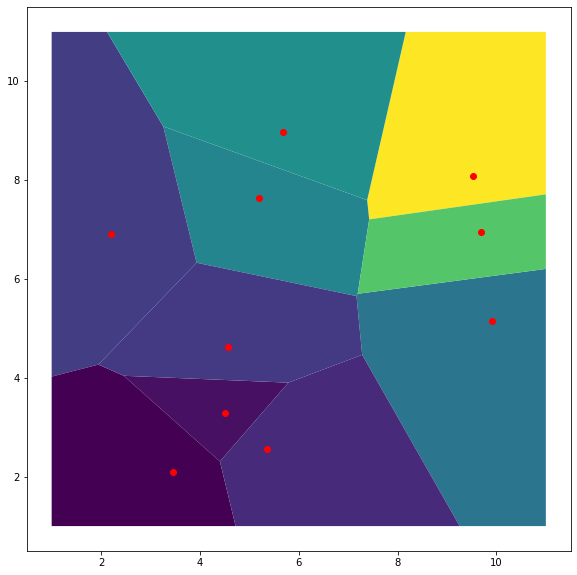

In [35]:
base = escore.plot(column='escore')
schools.plot(ax=base, color='red')

In [36]:
schools['escore2'] = escore.escore

In [37]:
schools.head()

,test_score,geometry,escore1,escore2
0,84.621952,POINT (9.51702 8.08617),843,774.494215
1,62.359065,POINT (5.19649 7.63378),457,405.918233
2,38.022265,POINT (2.20963 6.90364),244,218.149353
3,15.609321,POINT (4.51316 3.28197),119,126.892220
4,78.779343,POINT (5.67809 8.96656),457,435.307886


<AxesSubplot:xlabel='escore1', ylabel='escore2'>

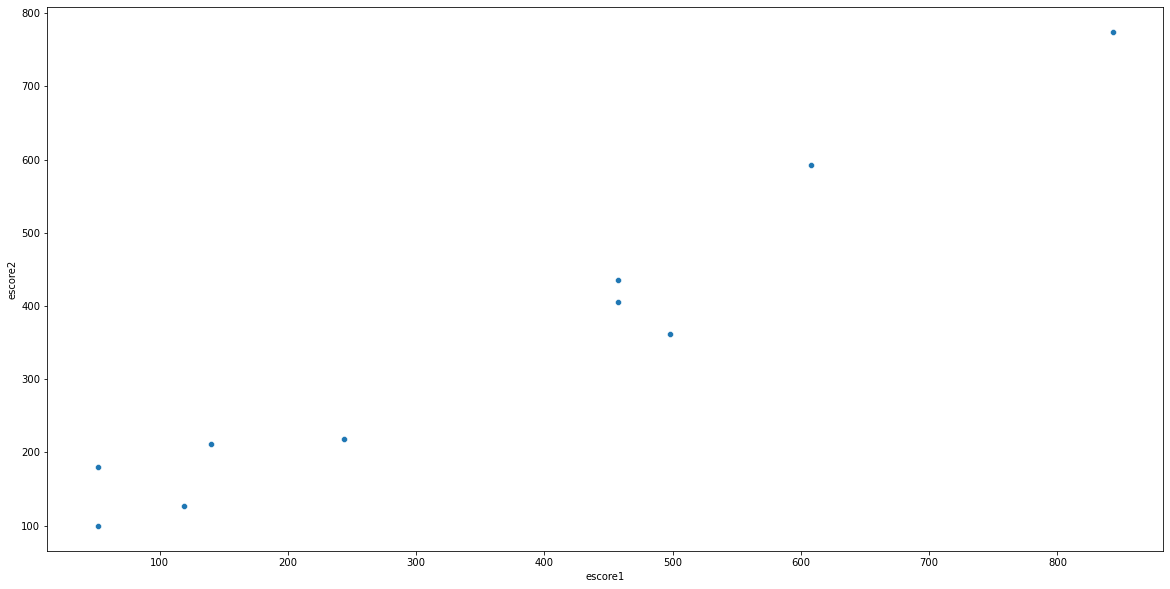

In [38]:
sns.scatterplot(data=schools, x="escore1", y="escore2")

<AxesSubplot:xlabel='escore1', ylabel='test_score'>

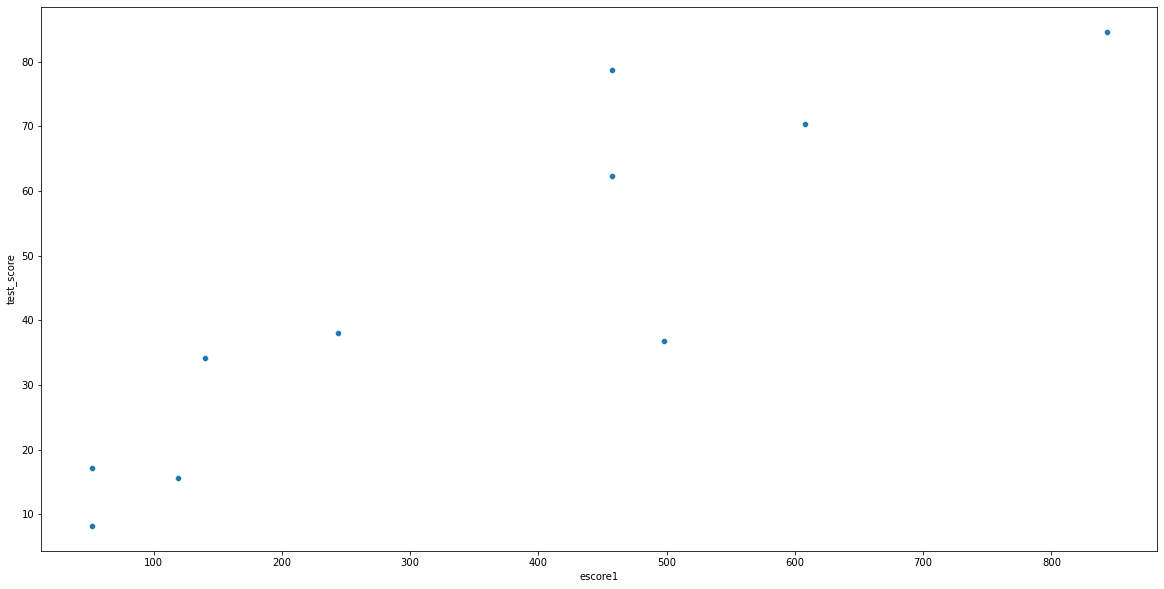

In [39]:
sns.scatterplot(data=schools, x="escore1", y="test_score")

<AxesSubplot:xlabel='escore2', ylabel='test_score'>

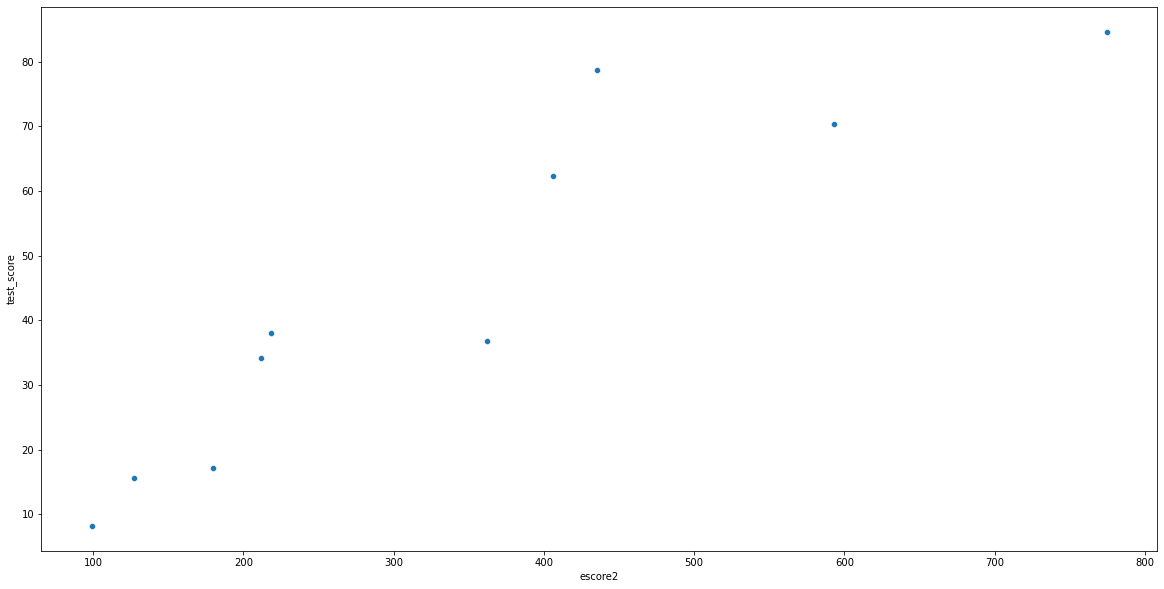

In [40]:
sns.scatterplot(data=schools, x="escore2", y="test_score")

### Racial Composition of the Schools

Two approaches:
    
 1. Take the value for the block group  that contains the school (1-1)
 2. Consruct a value that represents the racial composition  in the neighborhoods closes to the school (1-many)

<AxesSubplot:>

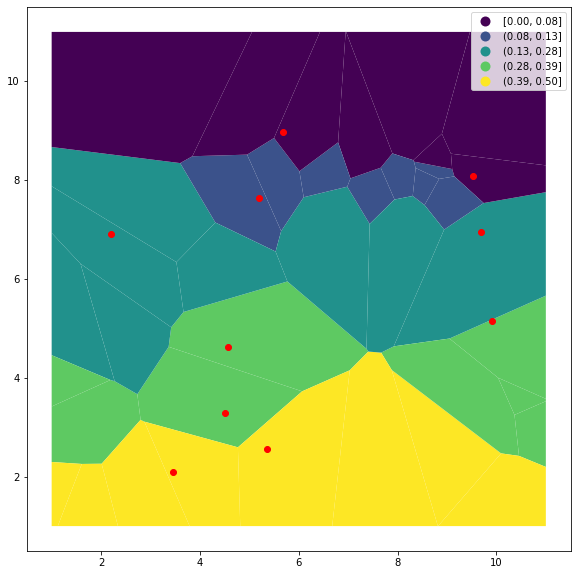

In [41]:
base = dem.plot(column='pctb', scheme='Quantiles', k=5, legend=True)
schools.plot(ax=base, color='red')

#### Approach 1 spatial join

In [42]:
pctb1 = gpd.sjoin(schools, dem, how='left', op='within')

In [43]:
pctb1.head()

,test_score,geometry,escore1,escore2,index_right,black,white,total,pctw,pctb
0,84.621952,POINT (9.51702 8.08617),843,774.494215,13,30,370,400,0.9250,0.0750
1,62.359065,POINT (5.19649 7.63378),457,405.918233,3,44,356,400,0.8900,0.1100
2,38.022265,POINT (2.20963 6.90364),244,218.149353,7,83,317,400,0.7925,0.2075
3,15.609321,POINT (4.51316 3.28197),119,126.892220,19,138,262,400,0.6550,0.3450
4,78.779343,POINT (5.67809 8.96656),457,435.307886,32,25,375,400,0.9375,0.0625


In [44]:
schools_vd['pctb1'] = pctb1.pctb
schools['pctb1'] = pctb1.pctb

<AxesSubplot:>

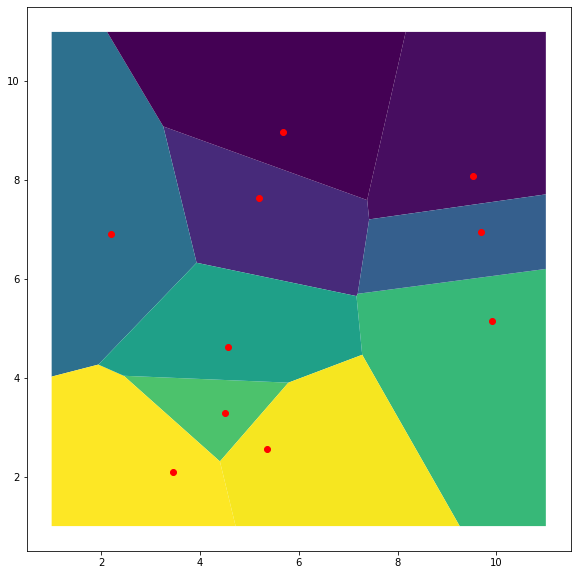

In [45]:
base = schools_vd.plot(column='pctb1')
schools.plot(ax=base, color='red')

#### Approach 2 areal interpolation

In [46]:
results = tob.area_weighted.area_interpolate(source_df=dem,
                                           target_df=schools_vd,
                                           intensive_variables=['pctb', 'pctw'],
                                            extensive_variables=['white', 'black'])

In [47]:
results.head()

,white,black,pctb,pctw,geometry
0,2972.281217,273.060048,0.067715,0.932285,"POLYGON ((7.38433 7.59660, 8.16484 11.00000, 8..."
1,1223.172996,172.133792,0.128812,0.871188,"POLYGON ((7.42521 7.20615, 7.19285 5.70034, 7...."
2,1269.920805,319.619277,0.144776,0.855224,"POLYGON ((2.12097 11.00000, 3.25846 9.08749, 3..."
3,190.506162,103.383458,0.349865,0.650135,"POLYGON ((5.79093 3.90251, 4.40474 2.30865, 2...."
4,1883.919691,117.184481,0.037641,0.962359,"POLYGON ((3.25846 9.08749, 2.12097 11.00000, 2..."


In [48]:
results['pctb1'] = results.black / (results.white + results.black)

In [49]:
results[['pctb', 'pctb1']].head()

,pctb,pctb1
0,0.067715,0.084139
1,0.128812,0.123366
2,0.144776,0.201077
3,0.349865,0.351776
4,0.037641,0.058560


In [50]:
schools['pctb2e'] = results.pctb
schools['pctb2i'] = results.pctb1

In [51]:
schools[['pctb1','pctb2i', 'pctb2e' ]].head()

,pctb1,pctb2i,pctb2e
0,0.0750,0.084139,0.067715
1,0.1100,0.123366,0.128812
2,0.2075,0.201077,0.144776
3,0.3450,0.351776,0.349865
4,0.0625,0.058560,0.037641


<AxesSubplot:xlabel='pctb2e', ylabel='test_score'>

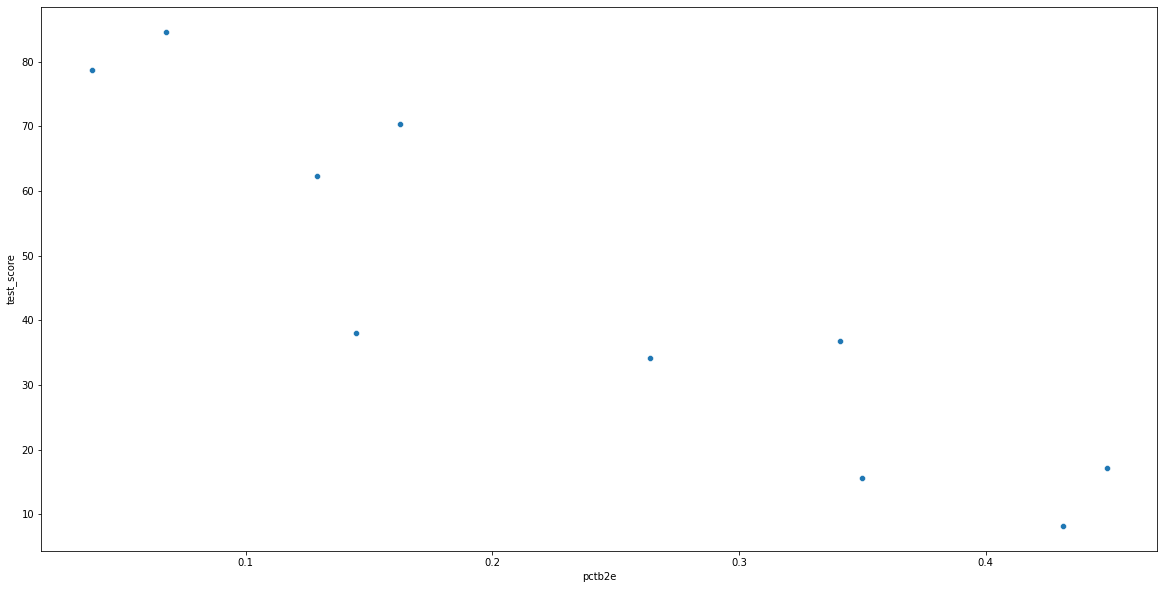

In [52]:
sns.scatterplot(data=schools, x="pctb2e", y="test_score")

<AxesSubplot:xlabel='pctb1', ylabel='test_score'>

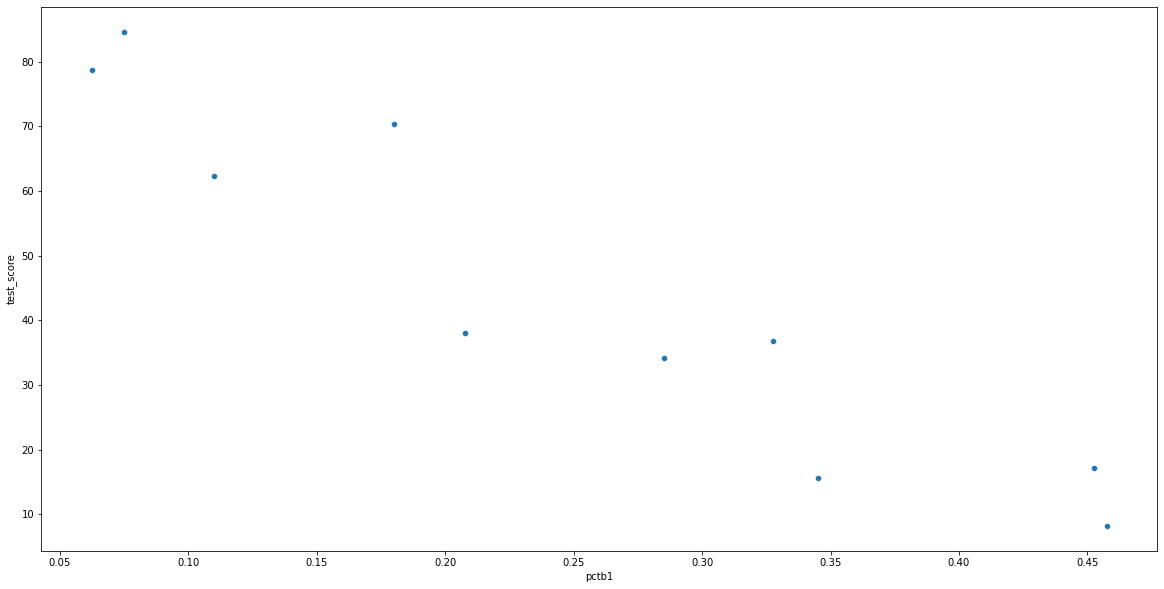

In [53]:
sns.scatterplot(data=schools, x="pctb1", y="test_score")

In [54]:
schools.head()

,test_score,geometry,escore1,escore2,pctb1,pctb2e,pctb2i
0,84.621952,POINT (9.51702 8.08617),843,774.494215,0.0750,0.067715,0.084139
1,62.359065,POINT (5.19649 7.63378),457,405.918233,0.1100,0.128812,0.123366
2,38.022265,POINT (2.20963 6.90364),244,218.149353,0.2075,0.144776,0.201077
3,15.609321,POINT (4.51316 3.28197),119,126.892220,0.3450,0.349865,0.351776
4,78.779343,POINT (5.67809 8.96656),457,435.307886,0.0625,0.037641,0.058560


<AxesSubplot:>

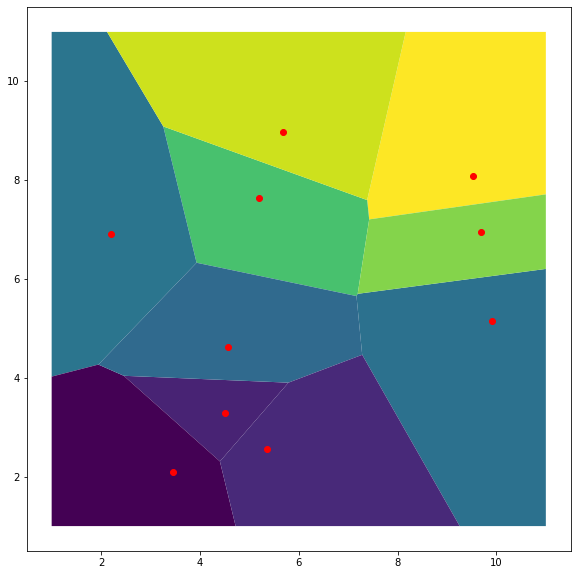

In [55]:
schools_vd['test_score'] = schools.test_score
base = schools_vd.plot(column='test_score')
schools.plot(ax=base, color='red')